# Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simular datos

In [38]:
# Se simula un dataset de jugadores de futbol 
# Las variables simuladas son: peso, altura, ganancias, partidos
# El dataset está generado por N(0,1) con unas correlaciones predefinidas

from scipy.linalg import cholesky
from scipy.stats import norm

# n = numero de jugadores (observaciones)
n= 2000

# Matriz de correlaciones entre las variables: peso, altura, ganancias, partidos
r = np.array([
        [  1,.9, 0, 0],
        [ .9, 1, 0, 0],
        [  0, 0, 1,.8],
        [  0, 0,.8, 1]])

# Generar muestras de cuatro variables N(0,1) independientes
indepes = norm.rvs(size=(4, n))

# Calcular la descomposición de Cholesky c tal que c*trans(c) = r
c = cholesky(r, lower=True)

# Simular las variables correlacionadas y guardarlas en W
W = np.dot(c,indepes).transpose()
variables=['Peso','Altura','Ganancias', 'Partidos']

# DATOS DE ENTRADA A LA SIGUIENTE FASE
df = pd.DataFrame(W,columns=variables) 

Vector de medias de las variables 
            Media
Peso       -0.04
Altura     -0.02
Ganancias   0.00
Partidos    0.00 
 
Matriz de covarianzas de las variables 
            Peso  Altura  Ganancias  Partidos
Peso       1.02    0.93       0.02      0.00
Altura     0.93    1.03       0.02      0.00
Ganancias  0.02    0.02       0.98      0.77
Partidos   0.00    0.00       0.77      0.97 
 



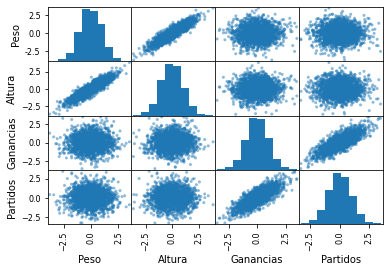

In [39]:
# VISUALIZAR LOS DATOS DE ENTRADA
# Medias y covarianzas de los datos simulados
medias=pd.DataFrame(np.mean(W,axis=0),index=variables,columns=['Media'])
covarianzas=pd.DataFrame(np.cov(df.transpose()),index=variables,columns=variables)
print('Vector de medias de las variables \n',np.round(medias,2) ,'\n','\n'
   'Matriz de covarianzas de las variables \n',np.round(covarianzas,2),'\n','\n')

# Gráfico XY cruzando todas las variables
pd.plotting.scatter_matrix(df);

# PCA con Scikit-Learn

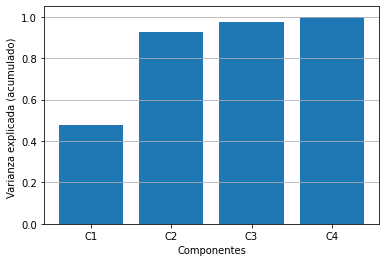

In [40]:
# Librerías PCA de Scykit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Estandarizar los datos de entrada df y guardarlos en X
estandarizar = StandardScaler()
estandarizar.fit(df)
X=estandarizar.transform(df) # X: Matriz de datos estandarizada de n x 4

# Definir el modelo cp (componentes principales)
cp= PCA()
cp.fit(X)

# Varianza explicada acumulada por los factores

componentes=['C1','C2','C3','C4']
plt.bar(componentes,
        height=np.cumsum(cp.explained_variance_ratio_))
plt.xlabel('Componentes')
plt.ylabel('Varianza explicada (acumulado) ')
plt.grid(axis='y');



# Heatmap de las loads (covarianzas entre variables y componentes)


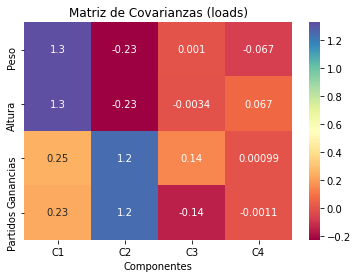

In [41]:
# Heatmap de las correlaciones entre variables y componentes
import seaborn as sns

# Calcular los loads y guardarlos en un DataFrame
scores=cp.transform(X)
loads=X.T@scores/(n-1)

dfloads=pd.DataFrame(loads,index=(variables),
                 columns=(componentes))

# Gráfico Heatmap
ax = sns.heatmap(dfloads, annot=True, cmap='Spectral')
ax.set_title('Matriz de Covarianzas (loads)')
ax.set_xlabel('Componentes');


# Biplot

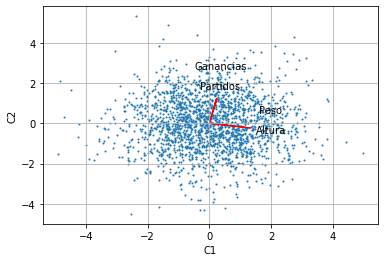

In [42]:
# Biplot: scores y covarianzas

def biplot(y,w,labels):
    
    n = w.shape[0]
    plt.scatter(y[:, 0], y[:, 1],s=1)
    for i in range(n):
        plt.arrow(0, 0, w[i,0], w[i,1],color = 'r')       
        plt.text(w[i,0]* 1.5, w[i,1] * 1.5+(i%2==0)*1, labels[i], 
                 color = 'black', ha = 'center', va = 'center')
 
    plt.xlabel("C{}".format(1))
    plt.ylabel("C{}".format(2))
    plt.grid()

biplot(scores,loads[:,0:2],df.columns) 



# Algunas identidades

In [43]:
# DEFINICION DE VARIABLES

W=cp.components_.T # matriz de autovectores (4x4)
Y=cp.transform(X) # matriz de las componentes (nx4)
ev=cp.explained_variance_ # vector con los autovalores (1x4)
A=np.diag(ev) # Matriz diagonal de autovalores (4x4)
sA=np.diag(np.sqrt(ev)) # Matriz diagonal de raiz cuadrada de autovalores (4x4)
isA=np.diag(np.sqrt(1/ev)) # Matriz diagonal de la inversa de la raiz cuadrada de autovalores (4x4)

S=np.cov(X.transpose()) # covarianzas de X
vY=sum(np.square(Y)/(n-1)) # varianzas de las componentes
covXY=X.T@Y/(n-1)
corXY=covXY@isA

# IDENTIDADES

# X@W=Y. Datos x pesos = scores
a=np.allclose(X@W-Y, np.zeros((n, 4)))

# ev=vY. Autovalores = Var(Y)
b=np.allclose(ev-vY, np.zeros((4,1)))

# X'Y/(n-1)= WA; X'XW=SW=WA Covarianzas XY = Autovectores x Autovalores 
c=np.allclose(covXY-W@A,np.zeros((4, 4)))

# corXY=W@sA. Correlaciones XY = Autovectores x Raiz de Autovalores
d=np.allclose(corXY-W@sA,np.zeros((4, 4)))

# La matriz de autovectores es ortonormal W*W'=I
e=np.allclose(W@W.T-np.identity(4),np.zeros((4, 4)))

print('Datos x pesos = scores:',a,
      '\nAutovalores = Var(Y):', b,
      '\nCovarianzas XY = Autovectores x Autovalores:', c,
      '\nCorrelaciones XY = Autovectores x Raiz de Autovalores:', d,
      '\nLa matriz de autovectores W es ortonormal:', e)


Datos x pesos = scores: True 
Autovalores = Var(Y): True 
Covarianzas XY = Autovectores x Autovalores: True 
Correlaciones XY = Autovectores x Raiz de Autovalores: True 
La matriz de autovectores W es ortonormal: True


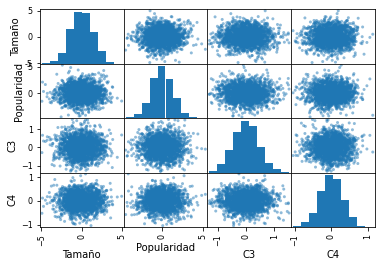

In [44]:
# Gráfico xy de los scores. Se observa que las componentes son independientes
# ordenadas de mayor a menor dispersión


sc= pd.DataFrame(Y, columns=['Tamaño','Popularidad','C3', 'C4'])
pd.plotting.scatter_matrix(sc);


# Reconstrucción. De los scores a los jugadores

Dado el jugador con scores y=(3,1,0,0) -->Tamaño = 3 (grande) Popularidad = -1 (baja). Los otros componentes se ignoran con valor 0 (media)

¿Cual sería su Peso, Altura, Ganancias, Partidos, conforme al modelo?

XW=Y --> X=YW' o también vector a vector

W'x=y Los vectores son verticales

WW'x=x=Wy 


Wy=x

In [64]:
y=np.array([3,-1,0,0])
x=W@y.T
x=np.round(x,2)
x=pd.DataFrame(x,index=variables,columns=(['jugador']))
x

,jugador
Peso,2.21
Altura,2.21
Ganancias,-0.30
Partidos,-0.34
